In [5]:
import numpy as np
import matplotlib.pyplot as plt
import json
from re_func import *

%config InlineBackend.figure_format = 'retina'

## 1. Keypoints 추출

In [13]:
with open("./point_sample/heewon.json", 'r') as f:
    json_data = json.load(f)

In [14]:
left_shoulder = get_keypoint_info(json_data[0], 5)
right_shoulder = get_keypoint_info(json_data[0], 6)
left_elbow = get_keypoint_info(json_data[0], 7)
right_elbow = get_keypoint_info(json_data[0], 8)
left_wrist = get_keypoint_info(json_data[0], 9)
right_wrist = get_keypoint_info(json_data[0], 10)
left_hip = get_keypoint_info(json_data[0], 11)
right_hip = get_keypoint_info(json_data[0], 12)
left_knee = get_keypoint_info(json_data[0], 13)
right_knee = get_keypoint_info(json_data[0], 14)
left_ankle = get_keypoint_info(json_data[0], 15)
right_ankle = get_keypoint_info(json_data[0], 16)

keypoints = [left_shoulder, right_shoulder, left_elbow, right_elbow, left_wrist, right_wrist,
             left_hip, right_hip, left_knee, right_knee, left_ankle, right_ankle]

In [27]:
keypoints

[[427.4884955087254, 182.10784436156305, 'left_shoulder'],
 [354.00804615088583, 189.88467244972514, 'right_shoulder'],
 [476.7904280494792, 183.72126482132413, 'left_elbow'],
 [310.6017021259135, 207.26402713522435, 'right_elbow'],
 [485.53463359036107, 225.42944193520182, 'left_wrist'],
 [309.4645691170168, 169.6284822040477, 'right_wrist'],
 [412.6742357738002, 290.6946279163935, 'left_hip'],
 [366.9840610907826, 290.120887133862, 'right_hip'],
 [438.3481010713819, 373.063702729207, 'left_knee'],
 [346.6532861423037, 374.41220400969996, 'right_knee'],
 [464.534584566135, 445.67504014274107, 'left_ankle'],
 [327.39942563710133, 444.54447352585976, 'right_ankle']]

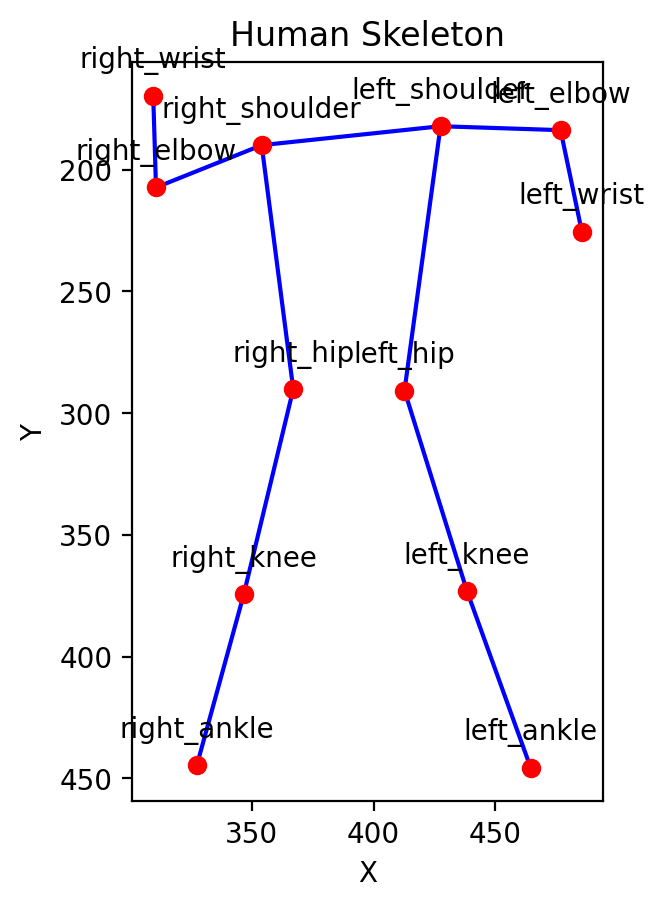

In [16]:
# 인체 뼈대 시각화
connections = [
    [0, 1],         # 어깨
    [0, 2],         # 왼쪽 상박
    [2, 4],         # 왼쪽 하박
    [1, 3],         # 오른쪽 상박
    [3, 5],         # 오른쪽 하박
    [0, 6],         # 왼쪽 허리
    [1, 7],         # 오른쪽 허리
    [6, 8],         # 왼쪽 허벅지
    [7, 9],         # 오른쪽 허벅지
    [8, 10],        # 왼쪽 종아리
    [9, 11]         # 오른쪽 종아리
]

fig, ax = plt.subplots()
ax.set_aspect('equal')

# 관절 연결하기
for connection in connections:
    start_idx, end_idx = connection[0], connection[1]
    start_point, end_point = keypoints[start_idx], keypoints[end_idx]
    ax.plot([start_point[0], end_point[0]], [start_point[1], end_point[1]], 'b')

# keypoint 찍기
for keypoint in keypoints:
    ax.plot(keypoint[0], keypoint[1], 'ro')
    ax.annotate(keypoint[2], (keypoint[0], keypoint[1]), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel('X')
plt.ylabel('Y')
ax.invert_yaxis()  # y축 반전
plt.title('Human Skeleton')
plt.show()

- y가 작은 것이 위로, 큰 것이 아래로 가게 상하반전 되어있음
- point가 정규화된 것으로 생각됨
---

## 2. angle 계산 방법 구현

### 1. 스켈레톤 각각의 arctan2의 차에 대한 절대값을 구하는 방법

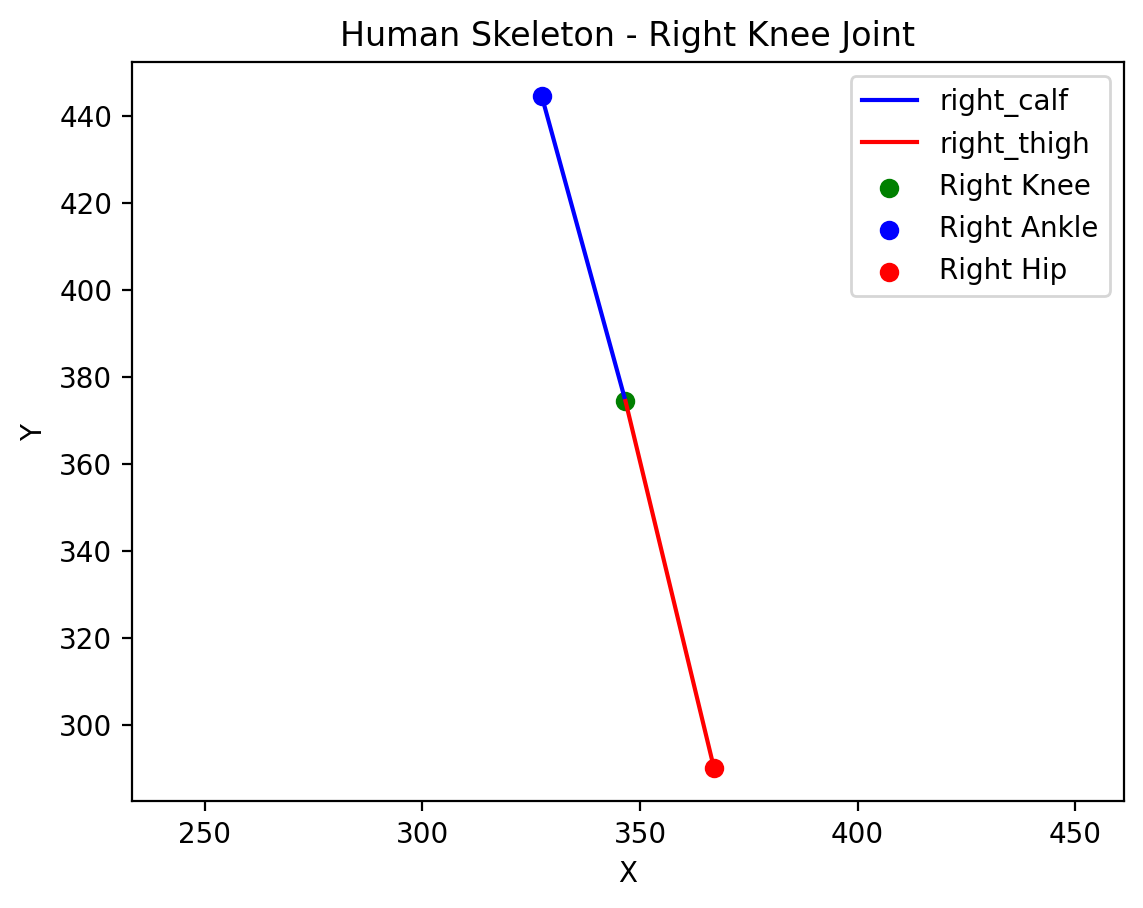

오른쪽 종아리 arctan2: -0.26793515074515534
오른쪽 허벅지 arctan2: 2.904916596719161
arctan2 차: 181.79101415041342
CPU times: user 426 ms, sys: 9.16 ms, total: 436 ms
Wall time: 159 ms


In [25]:
%%time

right_calf_angle = np.arctan2(right_ankle[0] - right_knee[0], right_ankle[1] - right_knee[1])
right_thigh_angle = np.arctan2(right_hip[0] - right_knee[0], right_hip[1] - right_knee[1])

# 인체 뼈대 시각화
plt.plot([right_knee[0], right_ankle[0]], [right_knee[1], right_ankle[1]], 'b', label='right_calf')
plt.plot([right_knee[0], right_hip[0]], [right_knee[1], right_hip[1]], 'r', label='right_thigh')
plt.scatter(right_knee[0], right_knee[1], color='g', label='Right Knee')
plt.scatter(right_ankle[0], right_ankle[1], color='b', label='Right Ankle')
plt.scatter(right_hip[0], right_hip[1], color='r', label='Right Hip')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Human Skeleton - Right Knee Joint')
plt.axis('equal')
plt.show()

print(f"오른쪽 종아리 arctan2: {right_calf_angle}")
print(f"오른쪽 허벅지 arctan2: {right_thigh_angle}")
print(f"arctan2 차: {abs(right_thigh_angle - right_calf_angle) * 180 / np.pi}")

- arctan2의 각을 구하고, 각을 radian에서 degree로 변환
- arctan2의 각은 x축과 해당 스켈레톤이 이루는 각 의미

### 2. 점과 점을 연결하여 벡터를 만들고 두 벡터 사이의 끼인 각을 벡터의 내적을 통해 구하는 방법

In [26]:
%%time

right_hip = np.array([keypoints[7][0], keypoints[7][1]])        # right_hip
right_knee = np.array([keypoints[9][0], keypoints[9][1]])       # right_knee
right_ankle = np.array([keypoints[11][0], keypoints[11][1]])    # right_ankle

# 벡터 생성
vector1 = abs(right_hip - right_knee)
vector2 = abs(right_knee - right_ankle)

print(f"오른쪽 허벅지 벡터: {vector1}")
print(f"오른쪽 종아리 벡터: {vector2}")

# 벡터의 크기
magnitude1 = np.linalg.norm(vector1)
magnitude2 = np.linalg.norm(vector2)

# 내적
dot_product = np.dot(vector1, vector2)

# 각도 계산
angle_rad = np.arccos(dot_product / (magnitude1 * magnitude2))
angle_deg = np.degrees(angle_rad)

print(f"두 벡터 사이의 끼인 각: {angle_deg}")

오른쪽 허벅지 벡터: [20.33077495 84.29131688]
오른쪽 종아리 벡터: [19.25386051 70.13226952]
두 벡터 사이의 끼인 각: 1.791014150413618
CPU times: user 289 µs, sys: 39 µs, total: 328 µs
Wall time: 304 µs
